In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim 

import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
data_dir = '../input/fptu-huynhld3-fall21'
train_dir = data_dir + '/train/train/'
test_dir = data_dir + '/test/test/'

In [3]:
import csv
import random

HDict = {}
for dirname, _, filenames in os.walk(train_dir):
    label = dirname.split('/')[-1]
    for filename in filenames:
        HDict[filename] = str(label)
        
l = list(HDict.items())
random.shuffle(l)
HDict = dict(l)

header = ['Id', 'Expected']

with open('train.csv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)

  # write the header
  writer.writerow(header)

  for row in HDict.items():
    writer.writerow(row)

In [4]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("/kaggle/working/train.csv")

train_df, val_df = train_test_split(df,test_size=0.3, random_state = 42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [5]:
val_df.head()

,Id,Expected
0,1030717321.jpg,1
1,862245162.jpg,1
2,1522028080.jpg,1
3,2108754386.jpg,1
4,968755787.jpg,1


In [6]:
import cv2

class ImageData(Dataset):
    def __init__(self, df, data_dir, transform):
        super().__init__()
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):       
        img_name = self.df.iloc[index,0]
        label = self.df.iloc[index,1]
        
        img_path = os.path.join(self.data_dir, str(label), img_name)
        image = cv2.imread(img_path)
        #image = mpimg.imread(img_path)
        #image = cv2.resize(image, (224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image)
        return image, label

In [7]:
train_transform = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Resize((224,224)),
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomRotation(20),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])

val_transform = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Resize((224, 224)),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])
train_dataset = ImageData(df = train_df, data_dir = train_dir, transform = train_transform)
val_dataset = ImageData(df = val_df, data_dir = train_dir, transform = val_transform)

train_dataloader = DataLoader(dataset = train_dataset, batch_size = 64)
val_dataloader = DataLoader(dataset = val_dataset, batch_size = 64)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


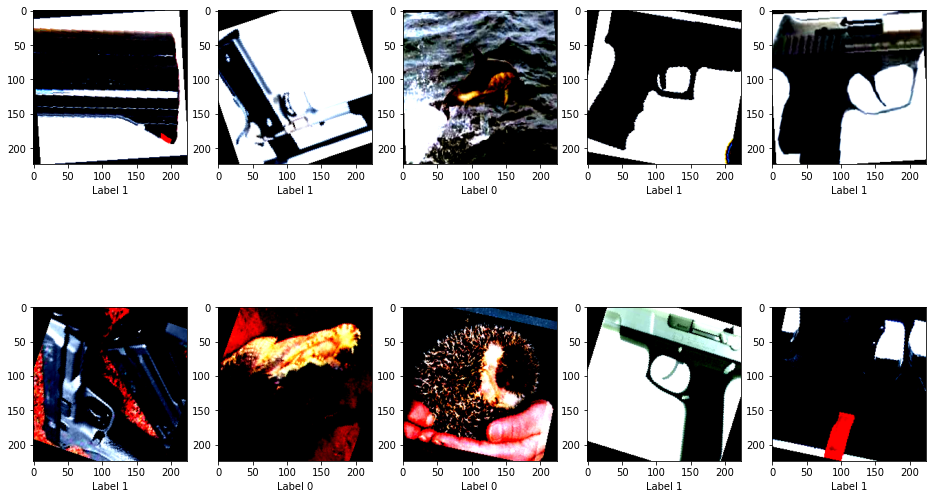

In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


plt.figure(figsize=(16,10))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.grid(False)
    img = train_features[i].squeeze()
    img = np.transpose(img,(1,2,0)) # Tranpose (Height, Width, Channels)
    plt.imshow(img)
    plt.xlabel("Label " + str(train_labels[i].item()))
plt.show()

### Download pretrained weights from Google Drive (My pretrained model)

In [9]:
# !conda install -y gdown

# !gdown --id 10Mn2lzTVy1zWl_V9_Ll3EED_PjXTCx9B

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device using {device}')

Device using cuda


In [11]:
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 743 kB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=274b7f002e326aab58abfcde9a6ff4a0144e0e197d216c1ae5c750530bcb0a0b
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [12]:
import pretrainedmodels

model_name = 'se_resnext101_32x4d' # could be fbresnet152 or inceptionresnetv2
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
dim_feats = model.last_linear.in_features # =2048
nb_classes = 1
model.last_linear = nn.Linear(dim_feats, nb_classes)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = True

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth" to /root/.cache/torch/hub/checkpoints/se_resnext101_32x4d-3b2fe3d8.pth


  0%|          | 0.00/187M [00:00<?, ?B/s]

In [13]:
# # # Resnet-50
# import torchvision.models as models
# def resnet50(pretrained=True, requires_grad=True):
#     model = models.resnext101_32x8d(progress=True, pretrained=pretrained)
# #     model = models.resnet152(progress=True, pretrained=pretrained)

#     # either freeze or train the hidden layer parameters
#     if requires_grad == False:
#         for param in model.parameters():
#             param.requires_grad = False
#     elif requires_grad == True:
#         for param in model.parameters():
#             param.requires_grad = True
#     # make the classification layer learnable
#     model.fc = nn.Linear(2048, 1)
#     return model

# model = resnet50()

# model = model.to(device)

In [14]:
# Stolen from https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [15]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
BCE_logits = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
early_stopping = EarlyStopping(patience=8, verbose=True)
scaler = torch.cuda.amp.GradScaler() # Mixed precision FP32 and FP16

In [16]:
train_losses = []
test_losses = []

avg_train_losses = []
avg_test_losses = []
for epoch in tqdm.trange(0, 30,desc='Epoch'):

    running_loss = 0.0
    model.train()
    correct = 0
    total = 0
    for data, target in tqdm.tqdm(train_dataloader, total=len(train_dataloader), desc='Train Batch',position=0, leave=True):
        data = data.to(device)
        target = target.to(device)
        
        target = target.float()    
        
        target = target.unsqueeze(1)

        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            output = model(data)                
    
            #m = nn.Sigmoid()
            #loss = criterion(m(output), target)
            loss = BCE_logits(output,target)
            
        #loss.backward()
        scaler.scale(loss).backward()

        #optimizer.step()  
        scaler.step(optimizer)
        
        running_loss += loss.item()
        train_losses.append(loss.item())
        
        total += target.size(0)
        output = torch.sigmoid(output)
        correct += ((output > 0.6).int() == target).sum().item()
        
        # Updates the scale for next iteration
        scaler.update()
    
    print("Epoch: {}, Loss: {}, Train Accuracy: {}".format(epoch, running_loss/len(train_dataloader), round(correct/total, 4)))
    
    train_loss = np.average(train_losses) # Calcalute average loss each epoch
    
    scheduler.step()
        
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm.tqdm(val_dataloader, total=len(val_dataloader), desc='Test Batch', position=0, leave=True):
            data, target = data.cuda(), target.cuda()
            
            target = target.float()    

            target = target.unsqueeze(1)

            output = model(data)                

            #m = nn.Sigmoid()
            
            #loss = criterion(m(output), target)
            loss = BCE_logits(output,target)
            
            running_loss += loss.item()
            test_losses.append(loss.item())

            total += target.size(0)
            output = torch.sigmoid(output)
            correct += ((output > 0.6).int() == target).sum().item()
            
    print("Epoch: {}, Loss: {}, Test Accuracy: {}\n".format(epoch, running_loss/len(val_dataloader), round(correct/total, 4)))
    
    test_loss = np.average(test_losses)
    
    avg_train_losses.append(train_loss)
    avg_test_losses.append(test_loss)
    
    # Clear loss after each epoch
    train_losses = []
    test_losses = []
        
    early_stopping(test_loss, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break


Train Batch: 100%|██████████| 159/159 [04:49<00:00,  1.82s/it]


Epoch: 0, Loss: 0.22785469880269008, Train Accuracy: 0.9107


Test Batch: 100%|██████████| 69/69 [01:09<00:00,  1.00s/it]


Epoch: 0, Loss: 0.1496503071832484, Test Accuracy: 0.9396

Validation loss decreased (inf --> 0.149650).  Saving model ...


Train Batch: 100%|██████████| 159/159 [03:48<00:00,  1.44s/it]


Epoch: 1, Loss: 0.1373885942025567, Train Accuracy: 0.9467


Test Batch: 100%|██████████| 69/69 [00:44<00:00,  1.56it/s]


Epoch: 1, Loss: 0.14093607942155306, Test Accuracy: 0.9431

Validation loss decreased (0.149650 --> 0.140936).  Saving model ...


Train Batch: 100%|██████████| 159/159 [03:48<00:00,  1.44s/it]


Epoch: 2, Loss: 0.11180064221551209, Train Accuracy: 0.9554


Epoch:  10%|█         | 3/30 [15:07<2:12:00, 293.36s/it]

Epoch: 2, Loss: 0.20360848747625732, Test Accuracy: 0.9261

EarlyStopping counter: 1 out of 8


Train Batch: 100%|██████████| 159/159 [03:44<00:00,  1.42s/it]


Epoch: 3, Loss: 0.10162015368213069, Train Accuracy: 0.962


Epoch:  13%|█▎        | 4/30 [19:32<2:02:22, 282.40s/it]

Epoch: 3, Loss: 0.21041711705966273, Test Accuracy: 0.9144

EarlyStopping counter: 2 out of 8


Train Batch: 100%|██████████| 159/159 [03:40<00:00,  1.39s/it]


Epoch: 4, Loss: 0.08339759446211956, Train Accuracy: 0.9688


Epoch:  17%|█▋        | 5/30 [23:53<1:54:23, 274.54s/it]

Epoch: 4, Loss: 0.14812228593813337, Test Accuracy: 0.9385

EarlyStopping counter: 3 out of 8


Train Batch: 100%|██████████| 159/159 [03:41<00:00,  1.39s/it]


Epoch: 5, Loss: 0.07589788222392588, Train Accuracy: 0.9708


Test Batch: 100%|██████████| 69/69 [00:40<00:00,  1.70it/s]


Epoch: 5, Loss: 0.08252013939689251, Test Accuracy: 0.9683

Validation loss decreased (0.140936 --> 0.082520).  Saving model ...


Train Batch: 100%|██████████| 159/159 [03:42<00:00,  1.40s/it]


Epoch: 6, Loss: 0.06991914970179398, Train Accuracy: 0.9718


Epoch:  23%|██▎       | 7/30 [32:39<1:42:45, 268.08s/it]

Epoch: 6, Loss: 0.1567182831493193, Test Accuracy: 0.949

EarlyStopping counter: 1 out of 8


Train Batch: 100%|██████████| 159/159 [03:51<00:00,  1.46s/it]


Epoch: 7, Loss: 0.04219589792279843, Train Accuracy: 0.9833


Test Batch: 100%|██████████| 69/69 [00:44<00:00,  1.56it/s]


Epoch: 7, Loss: 0.06380425823137056, Test Accuracy: 0.978

Validation loss decreased (0.082520 --> 0.063804).  Saving model ...


Train Batch: 100%|██████████| 159/159 [03:47<00:00,  1.43s/it]


Epoch: 8, Loss: 0.02456146138778788, Train Accuracy: 0.9911


Test Batch: 100%|██████████| 69/69 [00:40<00:00,  1.70it/s]


Epoch: 8, Loss: 0.05657055925078474, Test Accuracy: 0.9809

Validation loss decreased (0.063804 --> 0.056571).  Saving model ...


Train Batch: 100%|██████████| 159/159 [03:41<00:00,  1.39s/it]


Epoch: 9, Loss: 0.01516081287588561, Train Accuracy: 0.9956


Epoch:  33%|███▎      | 10/30 [46:06<1:29:13, 267.65s/it]

Epoch: 9, Loss: 0.05945361470736131, Test Accuracy: 0.9814

EarlyStopping counter: 1 out of 8


Train Batch: 100%|██████████| 159/159 [03:43<00:00,  1.41s/it]


Epoch: 10, Loss: 0.011017750506069651, Train Accuracy: 0.9966


Epoch:  37%|███▋      | 11/30 [50:30<1:24:26, 266.67s/it]

Epoch: 10, Loss: 0.05868137311156623, Test Accuracy: 0.9819

EarlyStopping counter: 2 out of 8


Train Batch: 100%|██████████| 159/159 [03:41<00:00,  1.39s/it]


Epoch: 11, Loss: 0.00838565188190979, Train Accuracy: 0.9975


Epoch:  40%|████      | 12/30 [54:53<1:19:35, 265.32s/it]

Epoch: 11, Loss: 0.06539505887591024, Test Accuracy: 0.9821

EarlyStopping counter: 3 out of 8


Train Batch: 100%|██████████| 159/159 [03:44<00:00,  1.41s/it]


Epoch: 12, Loss: 0.007816253132047717, Train Accuracy: 0.9973


Epoch:  43%|████▎     | 13/30 [59:18<1:15:12, 265.42s/it]

Epoch: 12, Loss: 0.06213598435051213, Test Accuracy: 0.9835

EarlyStopping counter: 4 out of 8


Train Batch: 100%|██████████| 159/159 [03:41<00:00,  1.39s/it]


Epoch: 13, Loss: 0.005516020362298356, Train Accuracy: 0.9982


Epoch:  47%|████▋     | 14/30 [1:03:42<1:10:40, 265.01s/it]

Epoch: 13, Loss: 0.06521954743758492, Test Accuracy: 0.9825

EarlyStopping counter: 5 out of 8


Train Batch: 100%|██████████| 159/159 [03:41<00:00,  1.39s/it]


Epoch: 14, Loss: 0.0037610000004437635, Train Accuracy: 0.9992


Epoch:  50%|█████     | 15/30 [1:08:04<1:06:02, 264.15s/it]

Epoch: 14, Loss: 0.06190652267031365, Test Accuracy: 0.9835

EarlyStopping counter: 6 out of 8


Train Batch: 100%|██████████| 159/159 [03:42<00:00,  1.40s/it]


Epoch: 15, Loss: 0.00337074356605815, Train Accuracy: 0.9992


Epoch:  53%|█████▎    | 16/30 [1:12:27<1:01:32, 263.75s/it]

Epoch: 15, Loss: 0.063449255757049, Test Accuracy: 0.9835

EarlyStopping counter: 7 out of 8


Train Batch: 100%|██████████| 159/159 [03:41<00:00,  1.40s/it]


Epoch: 16, Loss: 0.0023412881128253116, Train Accuracy: 0.9997


Epoch:  53%|█████▎    | 16/30 [1:16:50<1:07:14, 288.18s/it]

Epoch: 16, Loss: 0.06354438544561465, Test Accuracy: 0.9837

EarlyStopping counter: 8 out of 8
Early stopping


# Visualizing the Loss and the Early Stopping Checkpoint

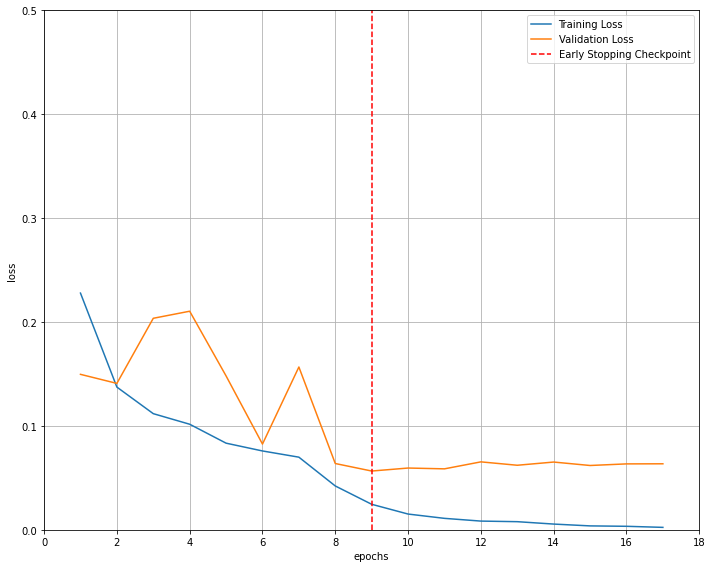

In [17]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_test_losses)+1),avg_test_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_test_losses.index(min(avg_test_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

# Make Submission

In [18]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [19]:
transform = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Resize((224, 224)),
                              transforms.ToTensor(),
                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])


HDict = {}
count = 0
for dirname, _, filenames in os.walk(test_dir):
    for filename in filenames:
        #print(dirname + filename)
        path = dirname + filename
        #print(path)
        image = cv2.imread(path)
        
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = transform(image)
            image = image.unsqueeze(0)
            
            image = image.cuda()
            
            model.eval()
            
            with torch.no_grad():
                output = model(image)
                
                output = torch.sigmoid(output)
                
                output = output.squeeze().item()
                
                if output > 0.7:
                    HDict[filename] = 1
                else:
                    HDict[filename] = 0
                    
            if count % 500 == 0:
                print(f"Count {count}")
            count += 1

Count 0
Count 500
Count 1000
Count 1500
Count 2000
Count 2500
Count 3000
Count 3500
Count 4000
Count 4500


In [20]:
header = ['Id', 'Expected']

with open('se_resnext101_32x4d_0.7_bs64_submission.csv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)

  # write the header
  writer.writerow(header)

  for row in HDict.items():
    writer.writerow(row)

# Visualization

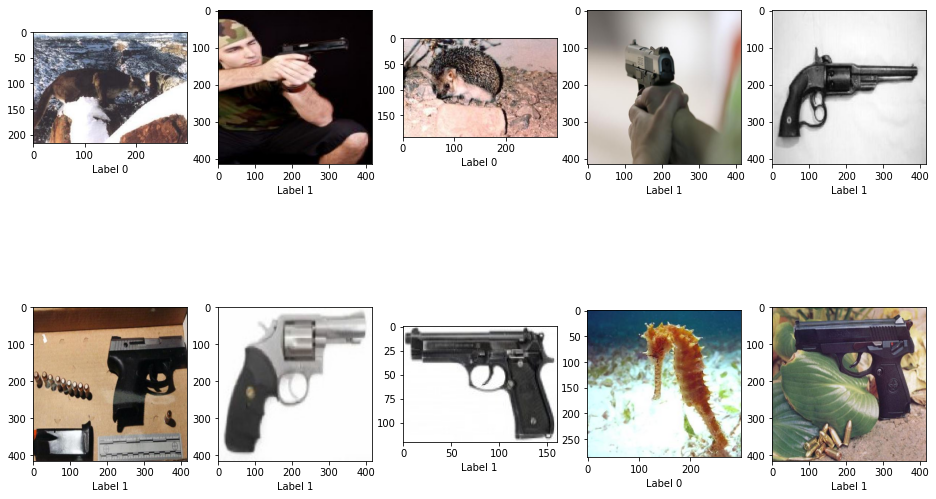

In [21]:
img_paths = list(HDict.keys())

plt.figure(figsize=(16,10))
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.grid(False)
    img = cv2.imread('../input/fptu-huynhld3-fall21/test/test/' + img_paths[i*100])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.xlabel("Label " + str(HDict[img_paths[i*100]]))
plt.show()